# 15.1 심층 합성곱 신경망으로 이미지 분류

### 1차원 CNN 구현하기 

In [ ]:
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

In [ ]:
## 테스트
x = [1,3,2,4,5,6,1,3]
w=[1,0,3,1,2]

print('Conv1d 구현:', conv1d(x, w, p=2, s=1))

Conv1d 구현: [ 5. 14. 16. 26. 24. 34. 19. 22.]


In [ ]:
print('넘파이 결과:', np.convolve(x, w, mode='same'))

넘파이 결과: [ 5 14 16 26 24 34 19 22]


### scipy로 2D 합성곱 구현하기

In [ ]:
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))


In [ ]:
X = [[1,3,2,4],[5,6,1,3],[1,2,0,2],[3,4,3,2]]
W = [[1,0,3],[1,2,1],[0,1,1]]

print('Conv2d 구현:\n', conv2d(X, W, p=(1,1), s=(1,1)))

Conv2d 구현:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]


In [ ]:
print('사이파이 결과 : \n',
      scipy.signal.convolve2d(X, W, mode='same'))

사이파이 결과 : 
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


# 15.2 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성 

In [ ]:
from tensorflow import keras
conv_layer = keras.layers.Conv2D(
    filters=16,
    kernel_size=(3,3),
    kernel_regularizer=keras.regularizers.l2(0.001))
fc_layer=keras.layers.Dense(
    units=16,
    kernel_regularizer=keras.regularizers.l2(0.001))

### 분류를 위한 손실 함수


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf 

### 이진 크로스 엔트로피
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)
tf.print(
    'BCE (확률) : {:.4f}'.format(bce_probas(y_true=[1], y_pred=probas)),
    'BCE (로짓): {:.4f}'.format(bce_logits(y_true=[1], y_pred=logits))
)


BCE (확률) : 0.3711 BCE (로짓): 0.3711


In [ ]:
### 범주형 크로스 엔트로피
cce_probas = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
logits = tf.constant([1.5, 0.8, 2.1])
probas = tf.keras.activations.sigmoid(logits)
tf.print(
    'CCE (확률) : {:.4f}'.format(cce_probas(y_true=[0,0,1], y_pred=probas)),
    'CCE (로짓): {:.4f}'.format(cce_logits(y_true=[0,0,1], y_pred=logits))
)

CCE (확률) : 0.5996 CCE (로짓): 0.5996


In [ ]:
####### 희소 범주형 크로스 엔트로피
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)
logits = tf.constant([1.5, 0.8, 2.1])
probas = tf.keras.activations.sigmoid(logits)
tf.print(
    'Sparse CCE (확률): {:.4f}'.format(
    sp_cce_probas(y_true=[2], y_pred=probas)),
    'Sparse CCE (로짓): {:.4f}'.format(
    sp_cce_logits(y_true=[2], y_pred=logits)))

Sparse CCE (확률): 0.5996 Sparse CCE (로짓): 0.5996


# 텐서플로를 사용하여 심층 합성곱 신경망 구현
## 데이터 적재와 전처리

In [6]:
import tensorflow_datasets as tfds
import tensorflow as tf

## 데이터 적재
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False) # 초기 셔플링을 막아줌
mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE =64
NUM_EPOCHS = 20
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
    tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                          tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)
mnist_train = mnist_train.shuffle(buffer_size = BUFFER_SIZE, 
                                  reshuffle_each_iteration = False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)


In [13]:
## 케라스로 CNN 구성하기 ##

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D( #합성곱층
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format= 'channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D( 
    pool_size =(2,2), name='pool_1'))
model.add(tf.keras.layers.Conv2D( #합성곱층
    filters=64, kernel_size=(5,5),
    strides=(1,1), padding='same',
    name='conv_2', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2), name='pool_2'))

In [14]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [15]:
model.add(tf.keras.layers.Flatten()) #밀집층 추가
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [16]:
model.add(tf.keras.layers. Dense(
      units=1024, name='fc_1',
      activation='relu'))
model.add(tf.keras.layers.Dropout(
    rate=0.5))
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax')) #열개의 출력 유닛을 가진 마지막 완전 연결층
    #소프트맥스 활성화 함수 사용

In [17]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [18]:
history = model.fit(mnist_train, epochs=NUM_EPOCHS,
                    validation_data= mnist_valid,
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 20s 12ms/step - loss: 0.1371 - accuracy: 0.9573 - val_loss: 0.0467 - val_accuracy: 0.9851
Epoch 2/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0446 - accuracy: 0.9865 - val_loss: 0.0416 - val_accuracy: 0.9875
Epoch 3/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0301 - accuracy: 0.9904 - val_loss: 0.0444 - val_accuracy: 0.9866
Epoch 4/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0223 - accuracy: 0.9929 - val_loss: 0.0346 - val_accuracy: 0.9898
Epoch 5/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0183 - accuracy: 0.9938 - val_loss: 0.0455 - val_accuracy: 0.9882
Epoch 6/20
782/782 [==============================] - 8s 9ms/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.0434 - val_accuracy: 0.9888
Epoch 7/20
782/782 [==============================] - 11s 12ms/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.0452 - val_accuracy: 0.9907
Ep

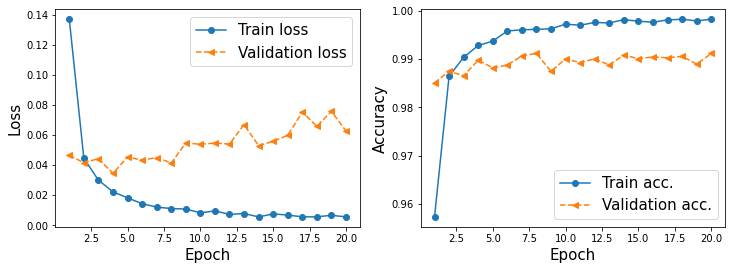

In [21]:
## 학습곡선 그리기 ##

import matplotlib.pyplot as plt
import numpy as np

hist = history.history

x_arr = np.arange(len(hist['loss'])) + 1
fig =plt.figure(figsize = (12, 4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [22]:
## 훈련된 모델 평가 ##
test_results = model.evaluate(mnist_test.batch(20))
print('테스트 정확도 : {:.2f}\%'.format(test_results[1]*100))

500/500 [==============================] - 2s 4ms/step - loss: 0.0384 - accuracy: 0.9929
테스트 정확도 : 99.29\%


In [23]:
## 입력과 예측 레이블 그래프로 그리기 ##

batch_test = next(iter(mnist_test.batch(12)))
preds = model(batch_test[0])
tf.print(preds.shape)

TensorShape([12, 10])


In [24]:
preds = tf.argmax(preds, axis=1)
print(preds)

tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


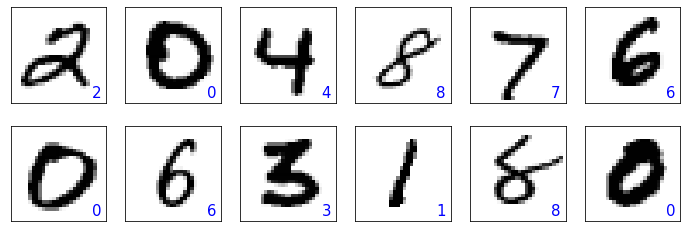

In [25]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
  ax = fig.add_subplot(2, 6, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  img = batch_test[0][i, :, :, 0]
  ax.imshow(img, cmap='gray_r')
  ax.text(0.9, 0.1, '{}'.format(preds[i]),
          size=15, color='blue',
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

plt.show()


# 15.4 합성곱 신경망을 사용하여 얼굴 이미지의 성별 분류

## CelebA 데이터셋 로드 

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds

celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files = False)
celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']


def count_items(ds):
  n = 0
  for _ in ds:
    n +=1
  return n
 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/162770 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteEMIVSE/celeb_a-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/19867 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteEMIVSE/celeb_a-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteEMIVSE/celeb_a-test.tfrecord*...:   0%|          |…

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


In [27]:
print('훈련 데이터셋: {}'.format(count_items(celeba_train)))
print('검증 데이터셋: {}'.format(count_items(celeba_valid)))
print('테스트 데이터셋 : {}'.format(count_items(celeba_test)))

훈련 데이터셋: 162770
검증 데이터셋: 19867
테스트 데이터셋 : 19962


## 이미지 변환과 데이터 증식

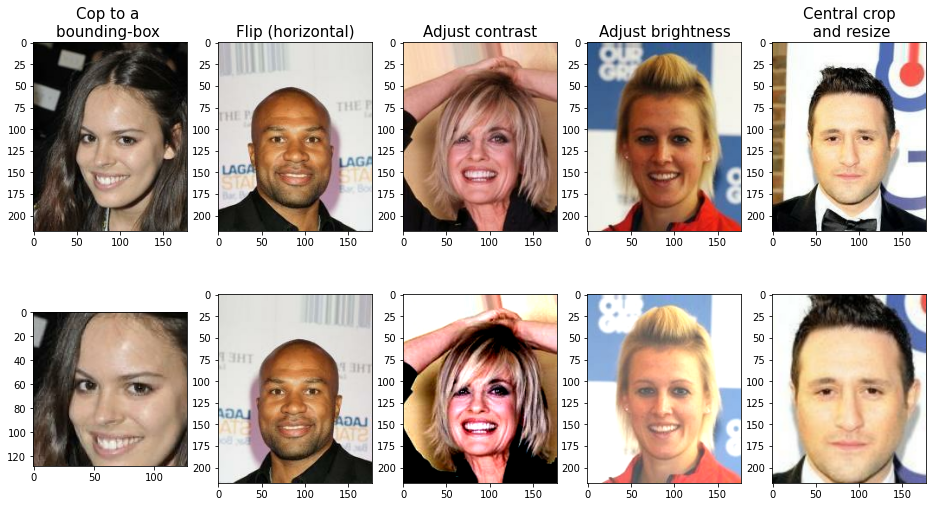

In [29]:
import matplotlib.pyplot as plt

# 다섯개의 샘플 가져오기
examples =[]

for example in celeba_train.take(5):
  examples.append(example['image'])
fig = plt.figure(figsize=(16, 8.5))

## 1열 : 바운딩 박스로 자르기
ax = fig.add_subplot(2, 5, 1)
ax.set_title('Cop to a \nbounding-box ', size=15)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
img_cropped = tf.image.crop_to_bounding_box(
    examples[0], 50, 20,128, 128)

ax.imshow(img_cropped)

## 2열 : 수평으로 뒤집기
ax= fig.add_subplot(2, 5, 2)
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)
ax = fig.add_subplot(2, 5, 3)
ax.set_title('Adjust contrast', size=15)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = tf.image.adjust_contrast(examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

## 4열 : 명도 조정
ax= fig.add_subplot(2, 5, 4)
ax.set_title('Adjust brightness', size=15)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = tf.image.adjust_brightness(
    examples[3], delta=0.3)
ax.imshow(img_adj_brightness)

## 5열 : 이미지 중앙 자르기
ax = fig.add_subplot(2, 5, 5)
ax.set_title('Central crop\n and resize', size=15)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
img_center_crop = tf.image.central_crop(
    examples[4], 0.7)

img_resized = tf.image.resize(
    img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))
plt.show()

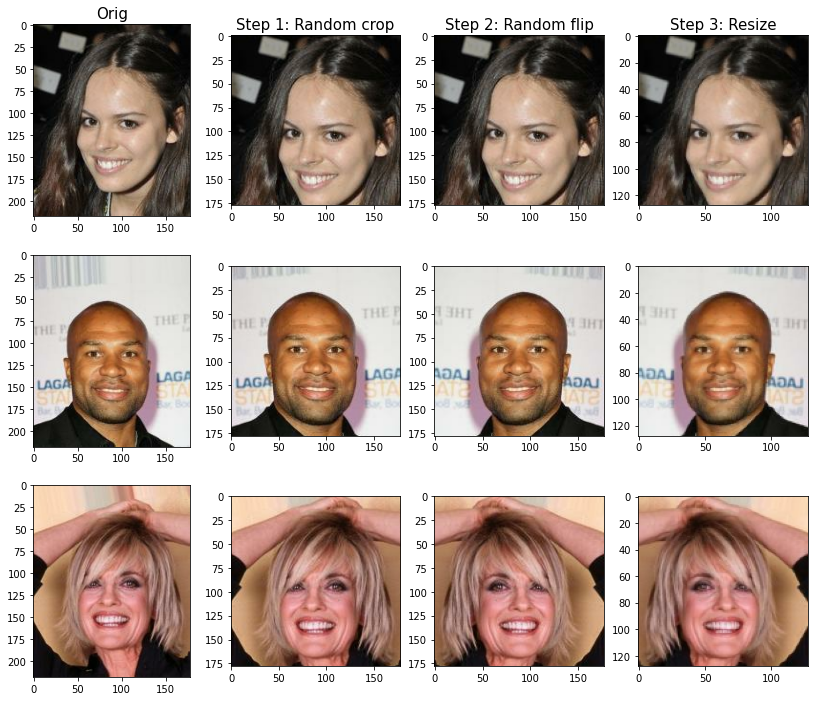

In [30]:
## 이미지를 랜덤하게 자라 내고 뒤집은 후 마지막으로 원하는 크기에 맞게 변환하기 ##

tf.random.set_seed(1)
fig = plt.figure(figsize=(14, 12))
for i, example in enumerate(celeba_train.take(3)):
  image = example['image']

  ax = fig.add_subplot(3, 4, i*4+1)
  ax.imshow(image)
  if i == 0:
    ax.set_title('Orig', size=15)

  ax = fig.add_subplot(3, 4, i*4+2)
  img_crop = tf.image.random_crop(image, size=(178, 178, 3))
  ax.imshow(img_crop)

  if i == 0:
    ax.set_title('Step 1: Random crop', size=15)

  ax = fig.add_subplot(3, 4, i*4+3)
  img_flip = tf.image.random_flip_left_right(img_crop)
  ax.imshow(tf.cast(img_flip, tf.uint8))
  if i == 0:
    ax.set_title('Step 2: Random flip', size=15)
  
  ax = fig.add_subplot(3,4, i*4+4)

  img_resize = tf.image.resize(img_flip, size=(128, 128))
  ax.imshow(tf.cast(img_resize, tf.uint8))

  if i == 0:
    ax.set_title('Step 3: Resize', size=15)

plt.show()

In [31]:
## 데이터 증식에 파이프라인 사용하기 ##

def preprocess(example, size=(64, 64), mode='train'):
  image = example['image']
  label = example['attributes']['Male']
  if mode == 'train':
    image_cropped = tf.image.random_crop(
        image, size=(178, 178, 3))
    image_resized= tf.image.resize(
        image_cropped, size=size)
    image_flip = tf.image.random_flip_left_right(
        image_resized)
    return image_flip/255.0, tf.cast(label, tf.int32)

  else: # 훈련 데이터가 아닌 경우 중앙부 잘라 내기
     image_cropped = tf.image.crop_to_bounding_box(
         image, offset_height=20, offset_width=0,
         target_height=178, target_width=178)
     image_resized = tf.image.resize(
         image_cropped, size=size)
     return image_resized/255.0, tf.cast(label, tf.int32)

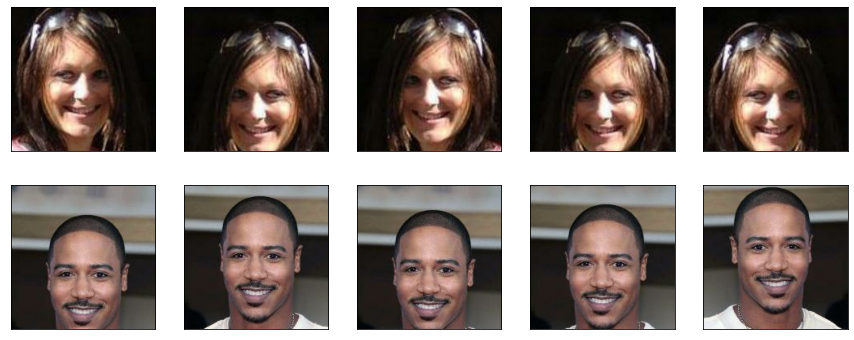

In [32]:
tf.random.set_seed(1)
ds = celeba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)
ds = ds.map(lambda x:preprocess(x, size=(178, 178), mode='train'))
fig = plt.figure(figsize=(15, 6))

for j, example in enumerate(ds):
  ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(example[0])

plt.show()

In [34]:
# 전처리 함수를 훈련 데이터셋과 검증 데이터셋에 적용

import numpy as np
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(16000/BATCH_SIZE)
ds_train = celeba_train.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size = BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)
ds_valid = celeba_valid.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

## CNN 성별 분류기 훈련 

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(
        64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(
        128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(
        256, (3,3), padding='same', activation='relu')
])

model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 8, 8, 256])

In [36]:
# 전역 평균 풀링층 추가
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 256])

In [37]:
## 출력 유닛이 한 개인 완전 연결층 추가

model.add(tf.keras.layers.Dense(1, activation=None))
tf.random.set_seed(1)
model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 64)       

In [38]:
## 모델 컴파일 ##
#손실 함수를 지정해주어야 함

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(ds_train, validation_data = ds_valid,
                    epochs=20,
                    steps_per_epoch = steps_per_epoch)



Epoch 1/20
500/500 [==============================] - 23s 42ms/step - loss: 0.6347 - accuracy: 0.6169 - val_loss: 0.5630 - val_accuracy: 0.7068
Epoch 2/20
500/500 [==============================] - 24s 47ms/step - loss: 0.5366 - accuracy: 0.7081 - val_loss: 0.4667 - val_accuracy: 0.7899
Epoch 3/20
500/500 [==============================] - 27s 54ms/step - loss: 0.4780 - accuracy: 0.7549 - val_loss: 0.4130 - val_accuracy: 0.7773
Epoch 4/20
500/500 [==============================] - 29s 57ms/step - loss: 0.4299 - accuracy: 0.7884 - val_loss: 0.3368 - val_accuracy: 0.8273
Epoch 5/20
500/500 [==============================] - 32s 65ms/step - loss: 0.3653 - accuracy: 0.8232 - val_loss: 0.2689 - val_accuracy: 0.8596
Epoch 6/20
500/500 [==============================] - 34s 68ms/step - loss: 0.3228 - accuracy: 0.8479 - val_loss: 0.2450 - val_accuracy: 0.8590
Epoch 7/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2897 - accuracy: 0.8654 - val_loss: 0.2225 - val_accuracy:

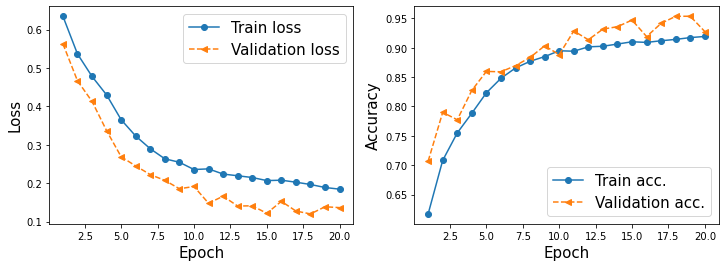

In [41]:
# 학습 곡선 그리기 #

hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [42]:
## 에포크를 추가하여 훈련 ##

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=30, initial_epoch=20,
                    steps_per_epoch = steps_per_epoch)

Epoch 21/30
500/500 [==============================] - 33s 63ms/step - loss: 0.1920 - accuracy: 0.9160 - val_loss: 0.1118 - val_accuracy: 0.9501
Epoch 22/30
500/500 [==============================] - 31s 62ms/step - loss: 0.1814 - accuracy: 0.9199 - val_loss: 0.1109 - val_accuracy: 0.9546
Epoch 23/30
500/500 [==============================] - 27s 53ms/step - loss: 0.1815 - accuracy: 0.9211 - val_loss: 0.1033 - val_accuracy: 0.9567
Epoch 24/30
500/500 [==============================] - 20s 40ms/step - loss: 0.1767 - accuracy: 0.9256 - val_loss: 0.1040 - val_accuracy: 0.9570
Epoch 25/30
500/500 [==============================] - 21s 41ms/step - loss: 0.1693 - accuracy: 0.9276 - val_loss: 0.1107 - val_accuracy: 0.9512
Epoch 26/30
500/500 [==============================] - 26s 52ms/step - loss: 0.1755 - accuracy: 0.9233 - val_loss: 0.1082 - val_accuracy: 0.9479
Epoch 27/30
500/500 [==============================] - 32s 64ms/step - loss: 0.1726 - accuracy: 0.9271 - val_loss: 0.1195 - val_ac

In [43]:
# 테스트 데이터셋으로 모델 평가
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)

test_results = model.evaluate(ds_test)
print('테스트 정확도: {:.2f}'.format(test_results[1]*100))

624/624 [==============================] - 9s 14ms/step - loss: 0.1226 - accuracy: 0.9450
테스트 정확도: 94.50


1/1 [==============================] - 0s 453ms/step


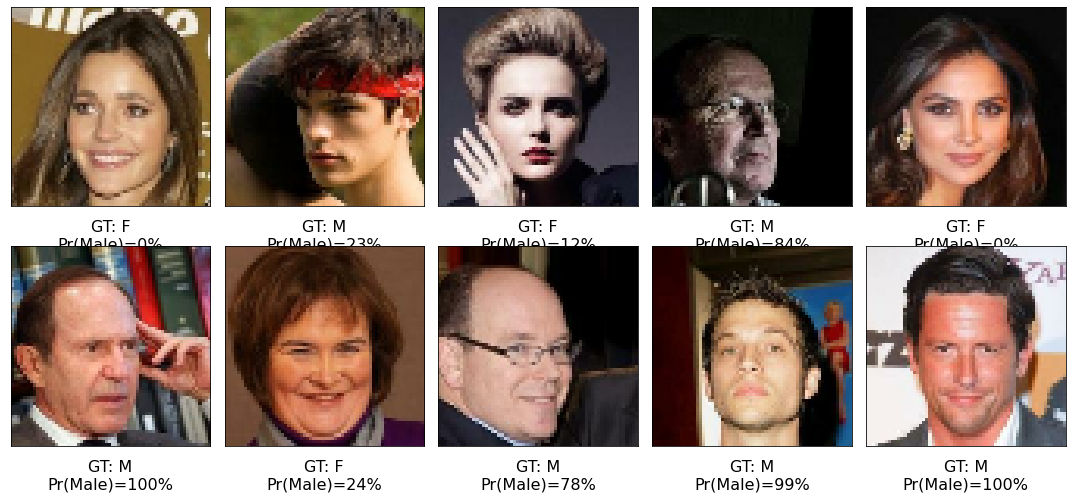

In [44]:
## 테스트 샘플의 예측 결과 얻기 ##

ds = ds_test.unbatch().take(10)
pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100
fig = plt.figure(figsize=(15, 7))
for j, example in enumerate(ds):
  ax = fig.add_subplot(2, 5, j+1)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(example[0])
  if example[1].numpy() == 1:
    label='M'
  else:
    label = 'F'
  ax.text(
      0.5, -0.15, 'GT: {:s}\nPr(Male)={:.0f}%'
      ''.format(label, probas[j]),
      size=16,
      horizontalalignment='center',
      verticalalignment='center',
      transform=ax.transAxes
  )

plt.tight_layout()
plt.show()